In [1]:
%matplotlib inline
import json
import numpy as np
from scipy.spatial.distance import cdist, euclidean
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import s3fs
fs = s3fs.S3FileSystem()
import boto3
import io

In [2]:
# you'll need to check the folder name, eg black-100-1561503934, manually. It will be however you
# defined job_name in run_labeling_jobs.
# In the current code job_name is the bucket name plus a timestamp, so the most recent job output
# will be the folder with the highest number at the end.

lbl_bucket = 'savedframes-bodhi-output/savedframes-bodhi-1595377922'

# first read the output manifest:
fid = 's3://{}/manifests/output/output.manifest'.format(lbl_bucket)
data = []
for line in fs.open(fid,'r'):
    data.append(json.loads(line))


In [3]:
# next we unpack the raw data from all individual annotators

nSamp   = len(data)
nKpts   = 7
nWorkers = 6
order   = ['nose','right ear','left ear','top of neck','right rear knee','left rear knee','base of tail']
keyName = 'annotatedResult' # name for the dict containing annotation data- this was set in run_labeling_job


# for each image: 7 keypoints, 2 dimensions, 6 workers per keypoint
rawPts = {'black': np.zeros((nSamp,nKpts,2,nWorkers)), 'white': np.zeros((nSamp,nKpts,2,nWorkers))}

images = ['']*nSamp        # track paths to labeled images
hits = [False]*nSamp       # track which images have annotations (only needed if a job failed to complete)
workerCount = [0]*nSamp    # track the number of workers who labeled each image (only needed if a job failed to complete)

sourceStr = os.path.dirname(data[0]['source-ref'])

for f,frame in enumerate(data):
    if (keyName in frame.keys()): #check if this frame has at least one set of annotations
        hits[f] = True

        images[f] = frame['source-ref']

        for w,worker in enumerate(frame[keyName]['annotationsFromAllWorkers']):
            workerCount[f] = workerCount[f] + 1

            # the json of annotations from each worker is stored as a string for security reasons.
            # we'll use eval to convert it into a dict:
            annot = eval(worker['annotationData']['content'])

            # now we can unpack this worker's annotations for each keypoint:
            for pt in annot[keyName]['keypoints']:
                mouse = 'black' if 'black' in pt['label'] else 'white'
                idx = order.index(pt['label'].replace(mouse,'').replace('mouse','').strip())
                
                rawPts[mouse][f,idx,0,w] = pt['x']
                rawPts[mouse][f,idx,1,w] = pt['y']


In [4]:
# we're going to set our ground-truth points as the geometric median of all the annotators.
# This algorithm for the geometric median comes from Vardi and Zhang 1999, as implemented by orlp on Stack Overflow
# (https://stackoverflow.com/questions/30299267/geometric-median-of-multidimensional-points)

def geometric_median(X, eps=1e-1):
    y = np.mean(X, 0)
    
    count=0
    while True:
        count=count+1
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1
        
        if count>10:
            return y1

        y = y1

In [5]:
# now let's get our ground-truth keypoints. (Note: this cell is slow!)

gtPts  = {'white':[],'black':[]}
allPts = {'white':[],'black':[]}

for mouse in ['white','black']:
    #first we'll take medians of the raw keypoints:
    gtPts[mouse] = np.zeros((nSamp,nKpts,2))
    for f,frame in enumerate(rawPts[mouse]):
        for p,pt in enumerate(frame):
            gtPts[mouse][f,p,:] = geometric_median(np.squeeze(pt.T))

    # then we'll adjust L/R assignments to try to find better median estimates. Iterating
    # seems to help settle on better final keypoints if the initial guesses were especially bad.
    for rep in range(3):
        # for ears and hips we should check for + correct Left/Right swaps, a common annotator mistake:
        allPts[mouse] = np.copy(rawPts[mouse])
        
        for fr,(gt,frame) in enumerate(zip(gtPts[mouse],rawPts[mouse])):
            for w,worker in enumerate(frame.swapaxes(0,2).swapaxes(1,2)):
                
                dEar1 = cdist(worker[1:3,:],[gt[1]])
                dEar2 = cdist(worker[1:3,:],[gt[2]])
                if (dEar1[0]>dEar1[1]) and (dEar2[1]>dEar1[0]):
                    allPts[mouse][fr,1,:,w] = rawPts[mouse][fr,2,:,w]
                    allPts[mouse][fr,2,:,w] = rawPts[mouse][fr,1,:,w]
                
                dHip1 = cdist(worker[4:6,:],[gt[4]])
                dHip2 = cdist(worker[4:6,:],[gt[5]])
                if (dHip1[0]>dHip1[1]) and (dHip2[1]>dHip2[0]):
                    allPts[mouse][fr,4,:,w] = rawPts[mouse][fr,5,:,w]
                    allPts[mouse][fr,5,:,w] = rawPts[mouse][fr,4,:,w]

        # then re-compute the medians:
        gtPts[mouse] = np.zeros((nSamp,nKpts,2))
        for f,frame in enumerate(allPts[mouse]):
            for p,pt in enumerate(frame):
                gtPts[mouse][f,p,:] = geometric_median(np.squeeze(pt.T))

In [23]:
import os
for fr in range(0,816):
    os.system('aws s3 cp ' + images[fr] + ' ' + images[fr].replace('s3://savedframes-bodhi','.'))



IndexError: list index out of range

In [3]:
import shutil
shutil.make_archive('saved_frames', 'zip', 'saved_frames')

'/home/ec2-user/SageMaker/asm-workflow/saved_frames.zip'

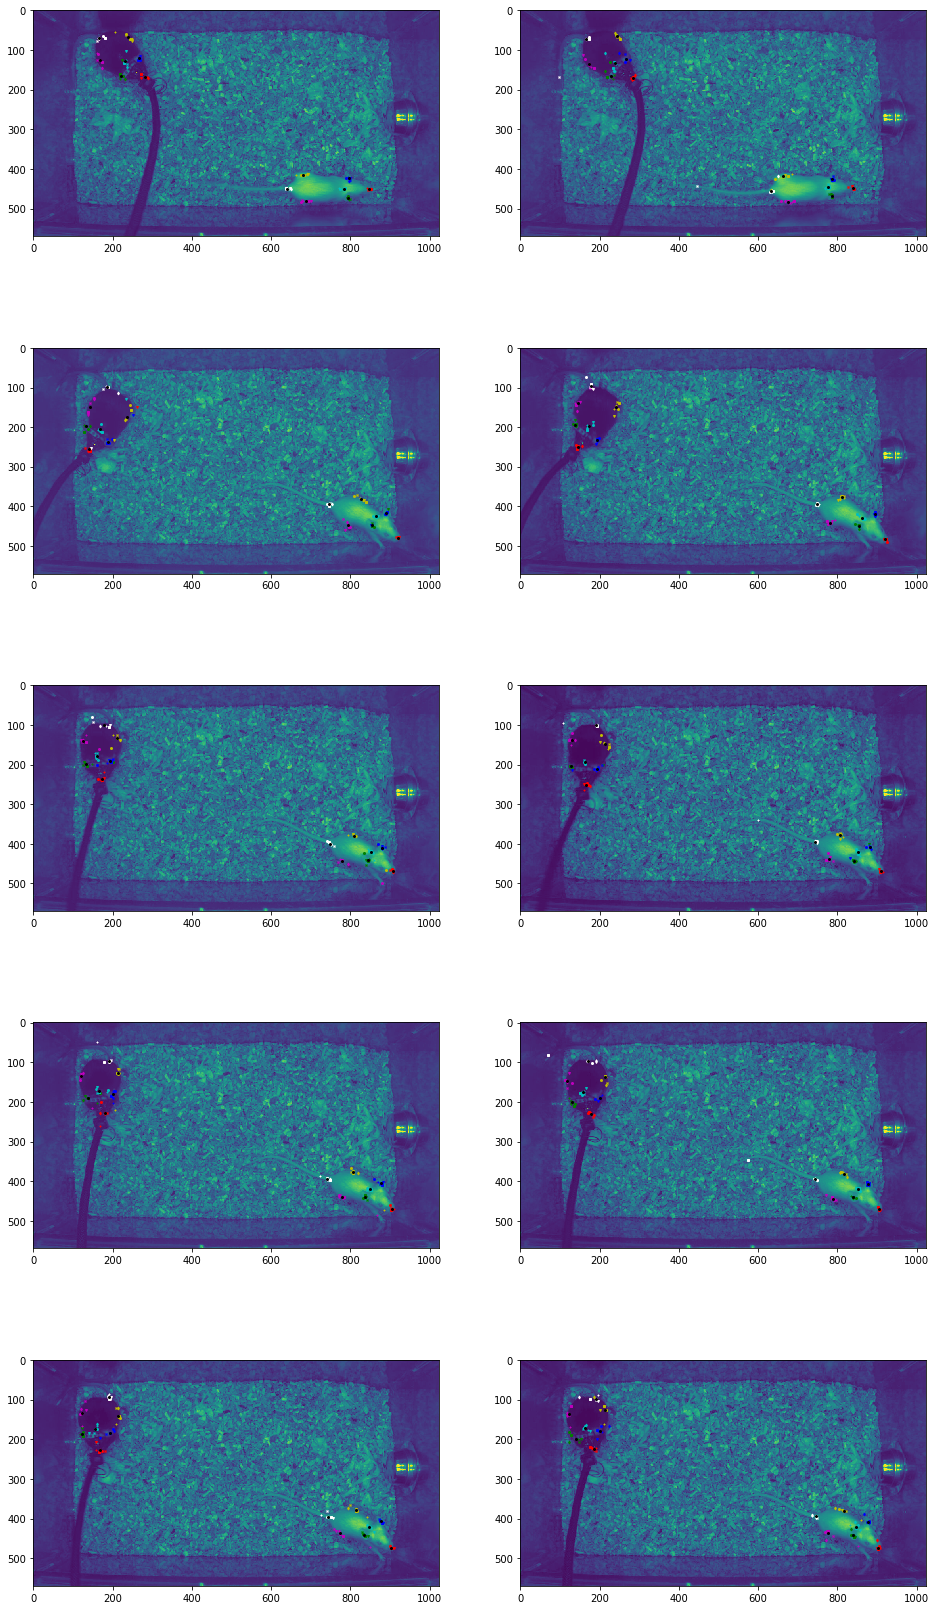

In [18]:
# let's look at a couple example images to see how our annotators did.
# (note, this also saves the figure as a pdf in lbl_bucket):

# each body part gets an assigned color; each annotator gets an assigned marker.
colors  = 'rgbcmyw'
markers = 'v+xosd'

s3 = boto3.resource('s3')
bucket = s3.Bucket('savedframes-bodhi')

file_stream = io.StringIO()


fig,ax = plt.subplots(5,2,figsize=(16, 30))
for fr in range(0,10):
    object = bucket.Object(images[fr].replace('s3://savedframes-bodhi/',''))
    file_stream = io.BytesIO()
    object.download_fileobj(file_stream)
    im = mpimg.imread(io.BytesIO(object.get()['Body'].read()), 'jpg')
    ax[int(fr/2),(fr+1)%2].imshow(im);
    
    # plot the labels from each individual worker:
    for mouse,mouseColor in zip(['white','black'],['w','k']):
        for p,pt in enumerate(np.squeeze(allPts[mouse][fr,...])):
            for w in range(nWorkers):
                ax[int(fr/2),(fr+1)%2].plot(pt[0,w], pt[1,w],colors[p] + markers[w], markersize=2)

        # plot the "ground truth" labels:
        ax[int(fr/2),(fr+1)%2].plot(gtPts[mouse][fr,:,0], gtPts[mouse][fr,:,1],'k.', markersize=4)

fig.savefig('sample_annotations.pdf', bbox_inches='tight')

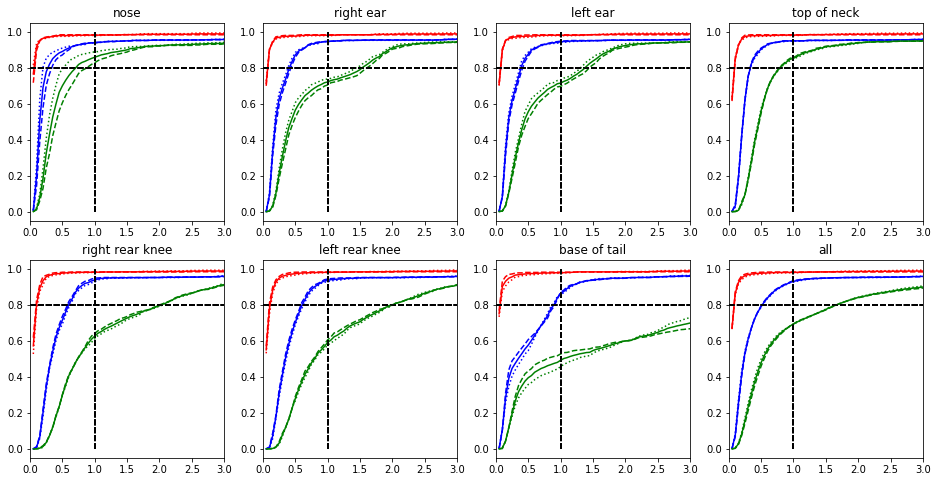

In [19]:
# now we'd like to quantify annotator variability. For some reason, this seems to be a good predictor
# of how well our pose estimator is going to do once trained.

pixels_per_cm = 37.795

fig,ax = plt.subplots(2,4,figsize=(16, 8))
dashes = {'white':'dotted', 'black':'dashed', 'both':'solid'}
colors = 'rbg'

for mouse in ['white','black','both']:
    if mouse != 'both':
        dMean = np.zeros((nKpts,nSamp)) # average worker-gt distance
        dMin  = np.zeros((nKpts,nSamp)) # performance of best worker on a given frame
        dMax  = np.zeros((nKpts,nSamp)) # performance of worst worker on a given frame
        for fr,(gt,est) in enumerate(zip(gtPts[mouse],allPts[mouse])):
            for pt,(gtPt,estPts) in enumerate(zip(gt,est)):
                D = cdist(estPts.T, [gtPt]) / pixels_per_cm
                dMean[pt,fr] = np.mean(D)
                dMin[pt,fr]  = min(D)
                dMax[pt,fr]  = max(D)
    else:
        dMean = np.zeros((nKpts,nSamp*2))
        dMin  = np.zeros((nKpts,nSamp*2))
        dMax  = np.zeros((nKpts,nSamp*2))
        for fr,(gt,est) in enumerate(zip(np.concatenate((gtPts['white'],gtPts['black'])), \
                                        np.concatenate((allPts['white'],allPts['black'])))):
            for pt,(gtPt,estPts) in enumerate(zip(gt,est)):
                D = cdist(estPts.T, [gtPt]) / pixels_per_cm
                dMean[pt,fr] = np.mean(D)
                dMin[pt,fr]  = min(D)
                dMax[pt,fr]  = max(D)

    showMax = 3
    bins = 10000
    binrange = [-1/bins, 500]

    for c,use in enumerate([dMin,dMean,dMax]):
        for p,pt in enumerate(use):
            counts,usedbins = np.histogram(pt,bins,range=binrange,density=True)
            ax[int(p/4),p%4].plot(usedbins[1:], counts.cumsum()/bins*binrange[1], colors[c], ls=dashes[mouse])
            ax[int(p/4),p%4].set_title(order[p])
            ax[int(p/4),p%4].set_xlim([0,showMax])
            ax[int(p/4),p%4].plot([1,1],[0,1],'k--')
            ax[int(p/4),p%4].plot([0,showMax],[.8,.8],'k--')

        counts,usedbins = np.histogram(use.ravel(),bins,range=binrange,density=True)
        ax[1,3].plot(usedbins[1:], counts.cumsum()/bins*binrange[1], colors[c], ls=dashes[mouse])
        ax[1,3].plot([1,1],[0,1],'k--')
        ax[1,3].plot([0,showMax],[.8,.8],'k--')
        ax[1,3].set_title('all');
        ax[1,3].set_xlim([0,showMax])

fig.savefig('performance.pdf', bbox_inches='tight')
#upload?
#s3_resource.Bucket('savedframes-bodhi').Object(img_name).upload_file('temp.jpg')